In [71]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [72]:
def process_image(image_path):
    image = cv2.imread(image_path) # görüntünün okunması
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gri tonlamalı görüntüye dönüştürme

    blurred = cv2.GaussianBlur(gray, (19, 19), 0) # Görüntüyü bulanıklaştırma

    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) # Görüntüyü ikili(binary) hale getirme
    thresh = cv2.bitwise_not(thresh) # ters çevirme

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 6)) # dikey çizgileri birleştirmek için 2,6 lık yapı elementi oluşturuldu
    closed_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel) # morfolojik close işlemi uygulandı

    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Contour bulma

    contour_image = np.zeros_like(gray)  # görüntünün üzerine çizebilmek için aynı boyutta boş bir görüntü oluşturuldu
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), thickness = cv2.FILLED)  # Contourları içi dolu beyaz şekiller halinde çizme

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(contour_image, 8, cv2.CV_32S) # Bağlı bileşenlerin etiketlenmesi
    connected_component_image = labels.copy()  # etiketlenmiş görüntüyü kopyalama
    filtered_components = np.zeros(contour_image.shape, dtype=np.uint8) # filtrelenmiş bileşenlerin tutulacağı görüntü
    for i in range(1, num_labels): # 0. etiket arka plan olduğu için 1 den başlandı
        if stats[i, cv2.CC_STAT_AREA] > 1100: # alanı 1100 den büyük olanları al gerisini ele
            filtered_components[labels == i] = 255 # filtrelenmiş bileşenleri beyaz yap

    kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (19, 19)) 
    open_image = cv2.morphologyEx(filtered_components, cv2.MORPH_OPEN, kernel_2) # morfolojik open işlemi uygulandı

    num_labels_2, labels_2, stats_2, centroids_2 = cv2.connectedComponentsWithStats(open_image, 8, cv2.CV_32S) # Bağlı bileşenlerin etiketlenmesi
    connected_component_image_2 = labels_2.copy() # etiketlenmiş görüntüyü kopyalama
    filtered_components_2 = np.zeros(open_image.shape, dtype=np.uint8) # filtrelenmiş bileşenlerin tutulacağı görüntü

    extracted_components = np.zeros_like(gray) # çıkarılan bileşenlerin tutulacağı görüntü

    for i in range(1, num_labels_2):
        ratio = stats_2[i, cv2.CC_STAT_WIDTH] / stats_2[i, cv2.CC_STAT_HEIGHT] # genişlik yükseklik oranı hesaplandı

        if 2 < ratio < 4: # oran 2 ile 4 arasında olan bileşenler alındı
            filtered_components_2[labels_2 == i] = 255
            # print(ratio)
            component_mask = (labels_2 == i) # bileşenin maskesi alındı

            extracted_component = gray * component_mask # bileşenin maskesi ile çarpıldı
            sum_of_component = np.sum(extracted_component) # bileşenin toplam değeri hesaplandı
            mean = sum_of_component / stats_2[i, cv2.CC_STAT_AREA] # bileşenin ortalaması hesaplandı
            # print("mean", mean)
            if mean > 80: # bileşenin ortalaması 80 den büyükse al
                extracted_components += extracted_component # çıkarılan bileşenler toplandı

    return gray,blurred,thresh,closed_image,filtered_components,open_image,filtered_components_2,extracted_components


libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


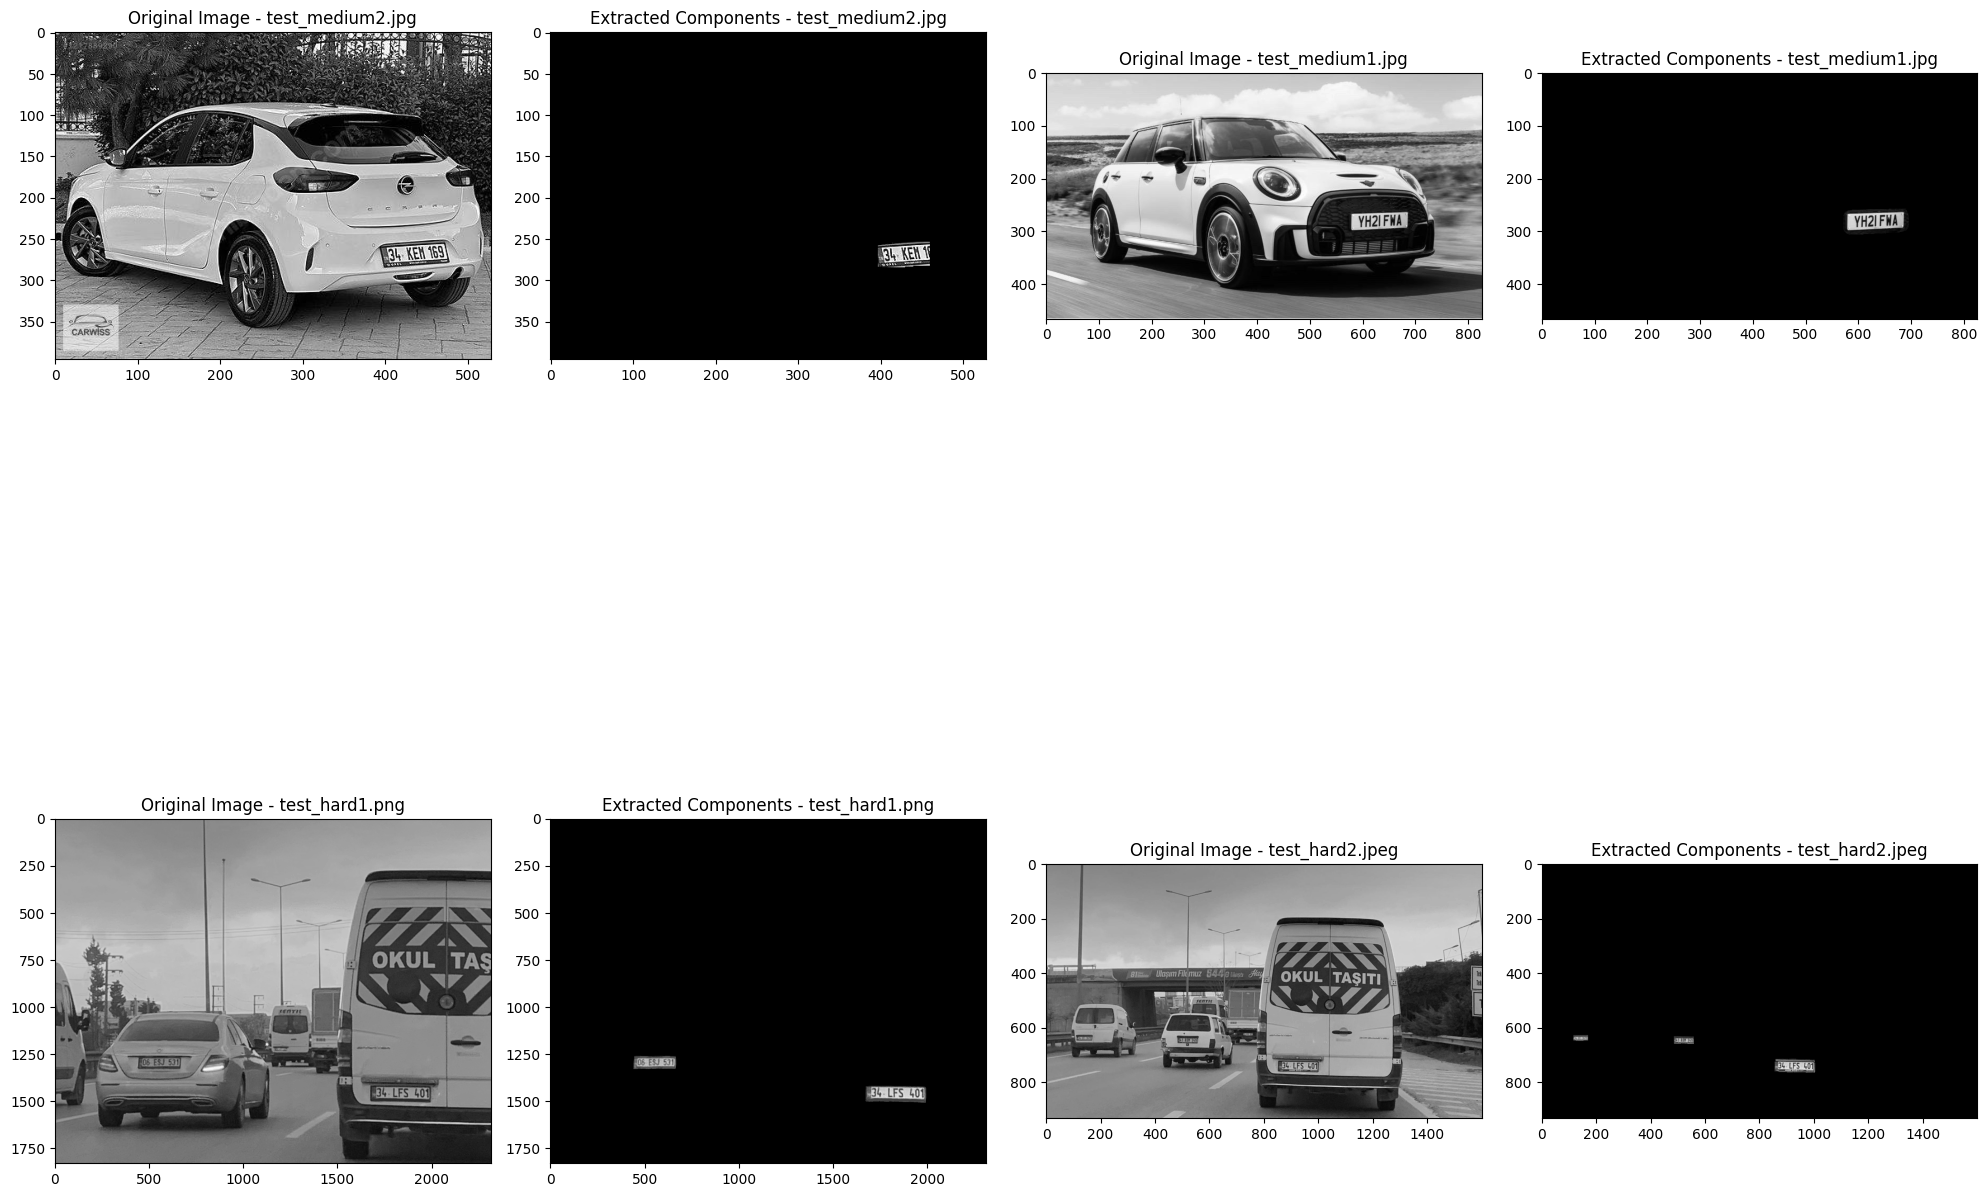

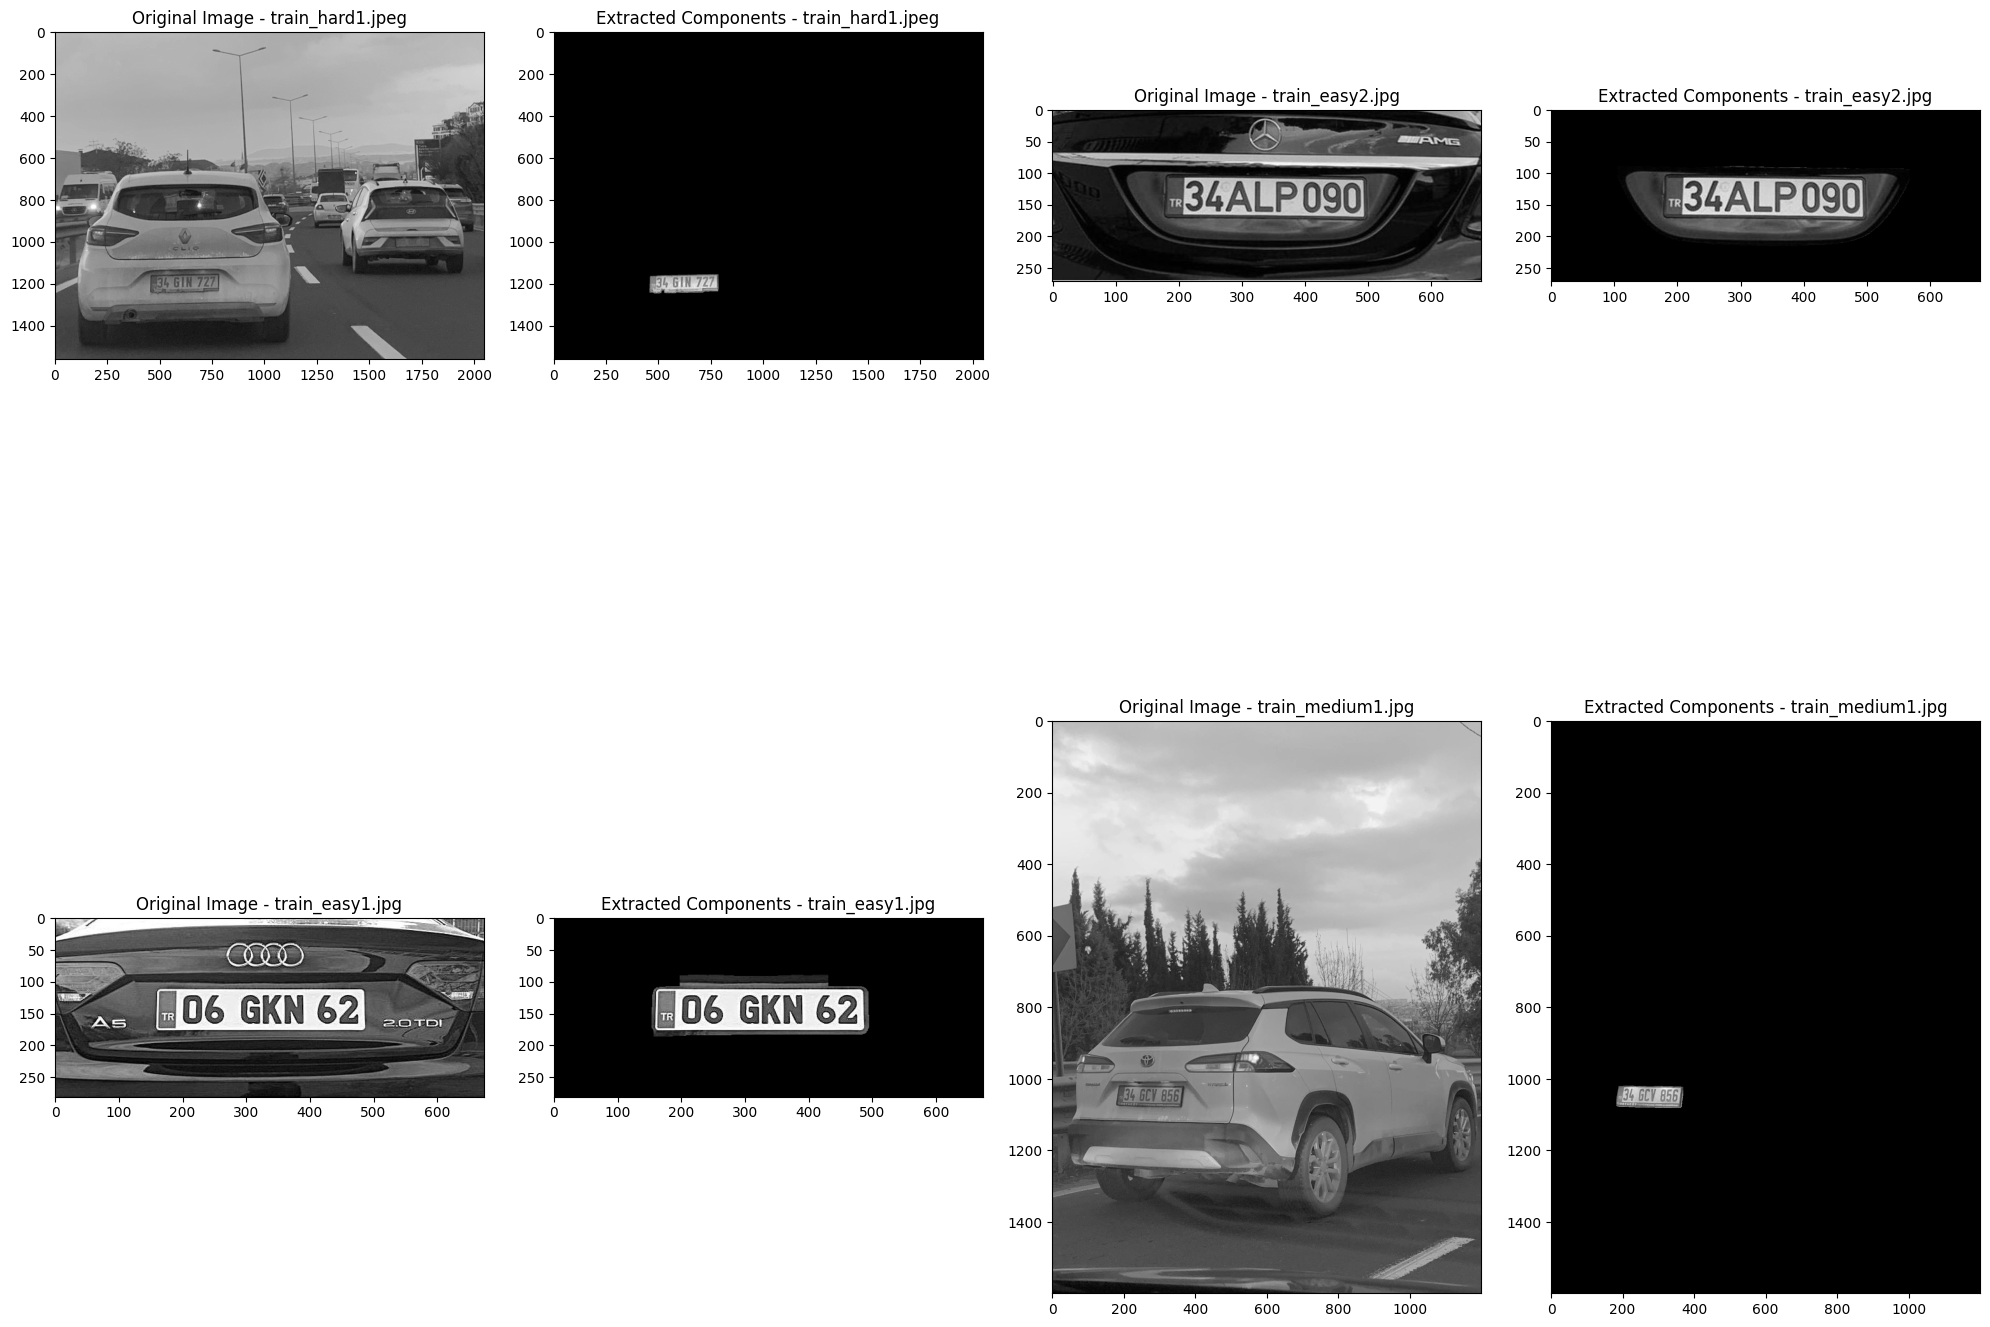

In [73]:
# orjinal ve çıkarılan sonuç bileşenlerinin gösterilmesi
def plot_extracted_components(folder_path):
    images = []
    extracted_images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            image_path = os.path.join(folder_path, filename)
            original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            _, _, _, _, _, _, _, extracted_components = process_image(image_path)
            images.append(original_image)
            extracted_images.append(extracted_components)
            filenames.append(filename)
    
    num_images = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 20))
    axes = axes.flatten()
    
    for i in range(min(num_images, 4)):
        axes[2*i].imshow(images[i], cmap='gray')
        axes[2*i].set_title(f"Original Image - {filenames[i]}")
        
        axes[2*i + 1].imshow(extracted_images[i], cmap='gray')
        axes[2*i + 1].set_title(f"Extracted Components - {filenames[i]}")
    
    plt.tight_layout()
    plt.show()


plot_extracted_components('images_gray/test_images/')
plot_extracted_components('images_gray/train_images/')

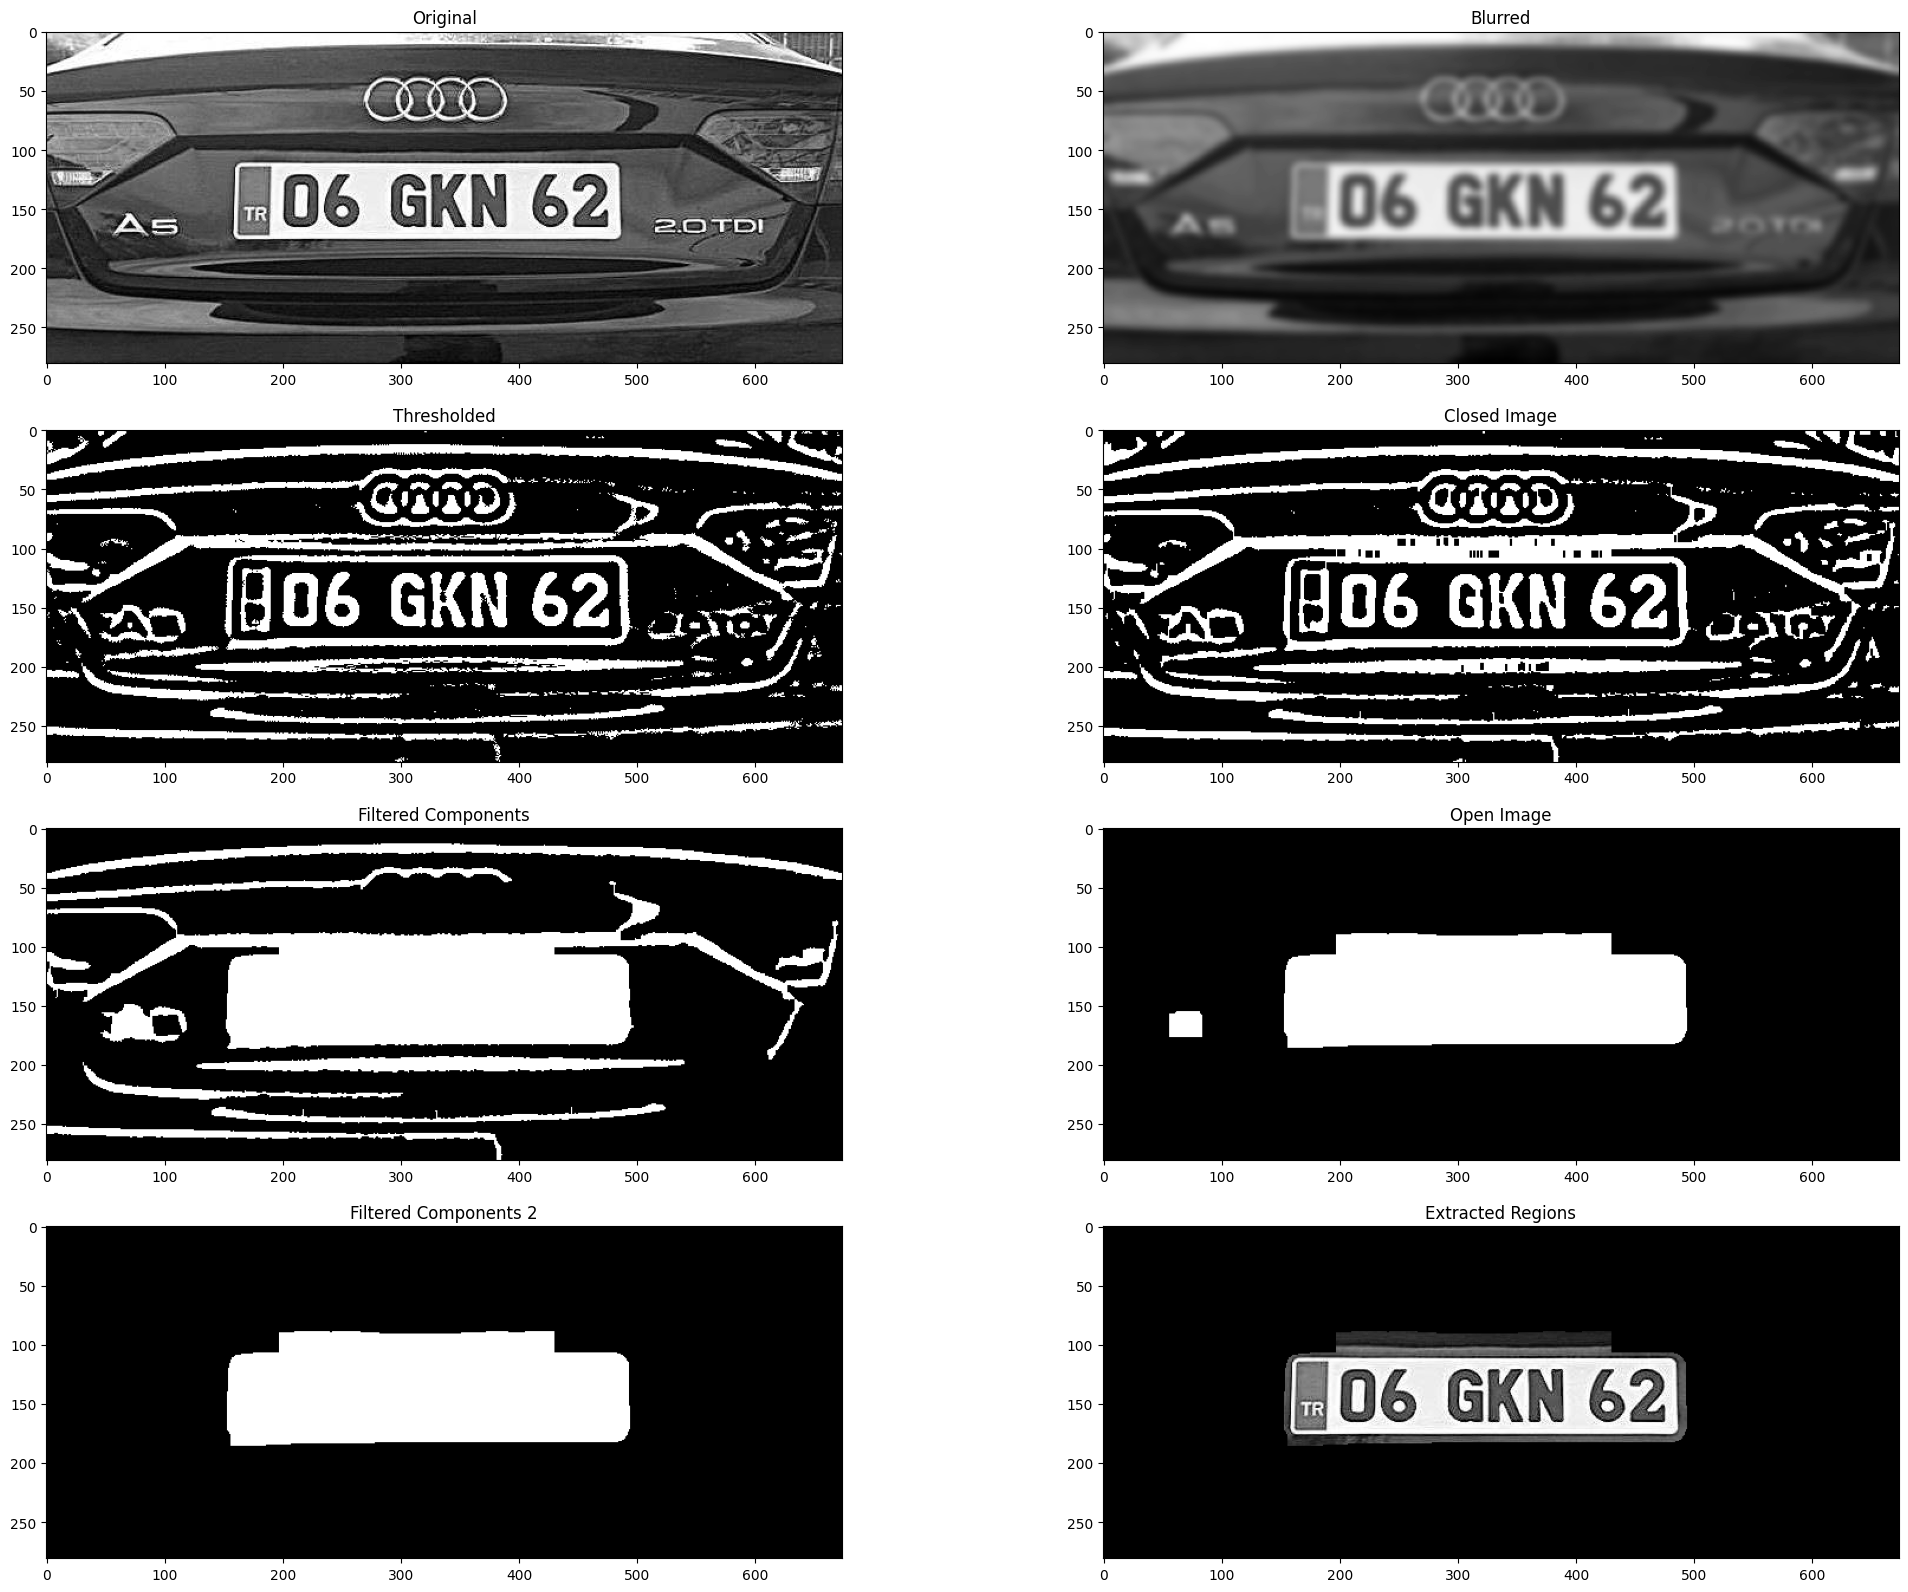

In [74]:
image_path = 'images_gray/train_images/train_easy1.jpg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(25, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()


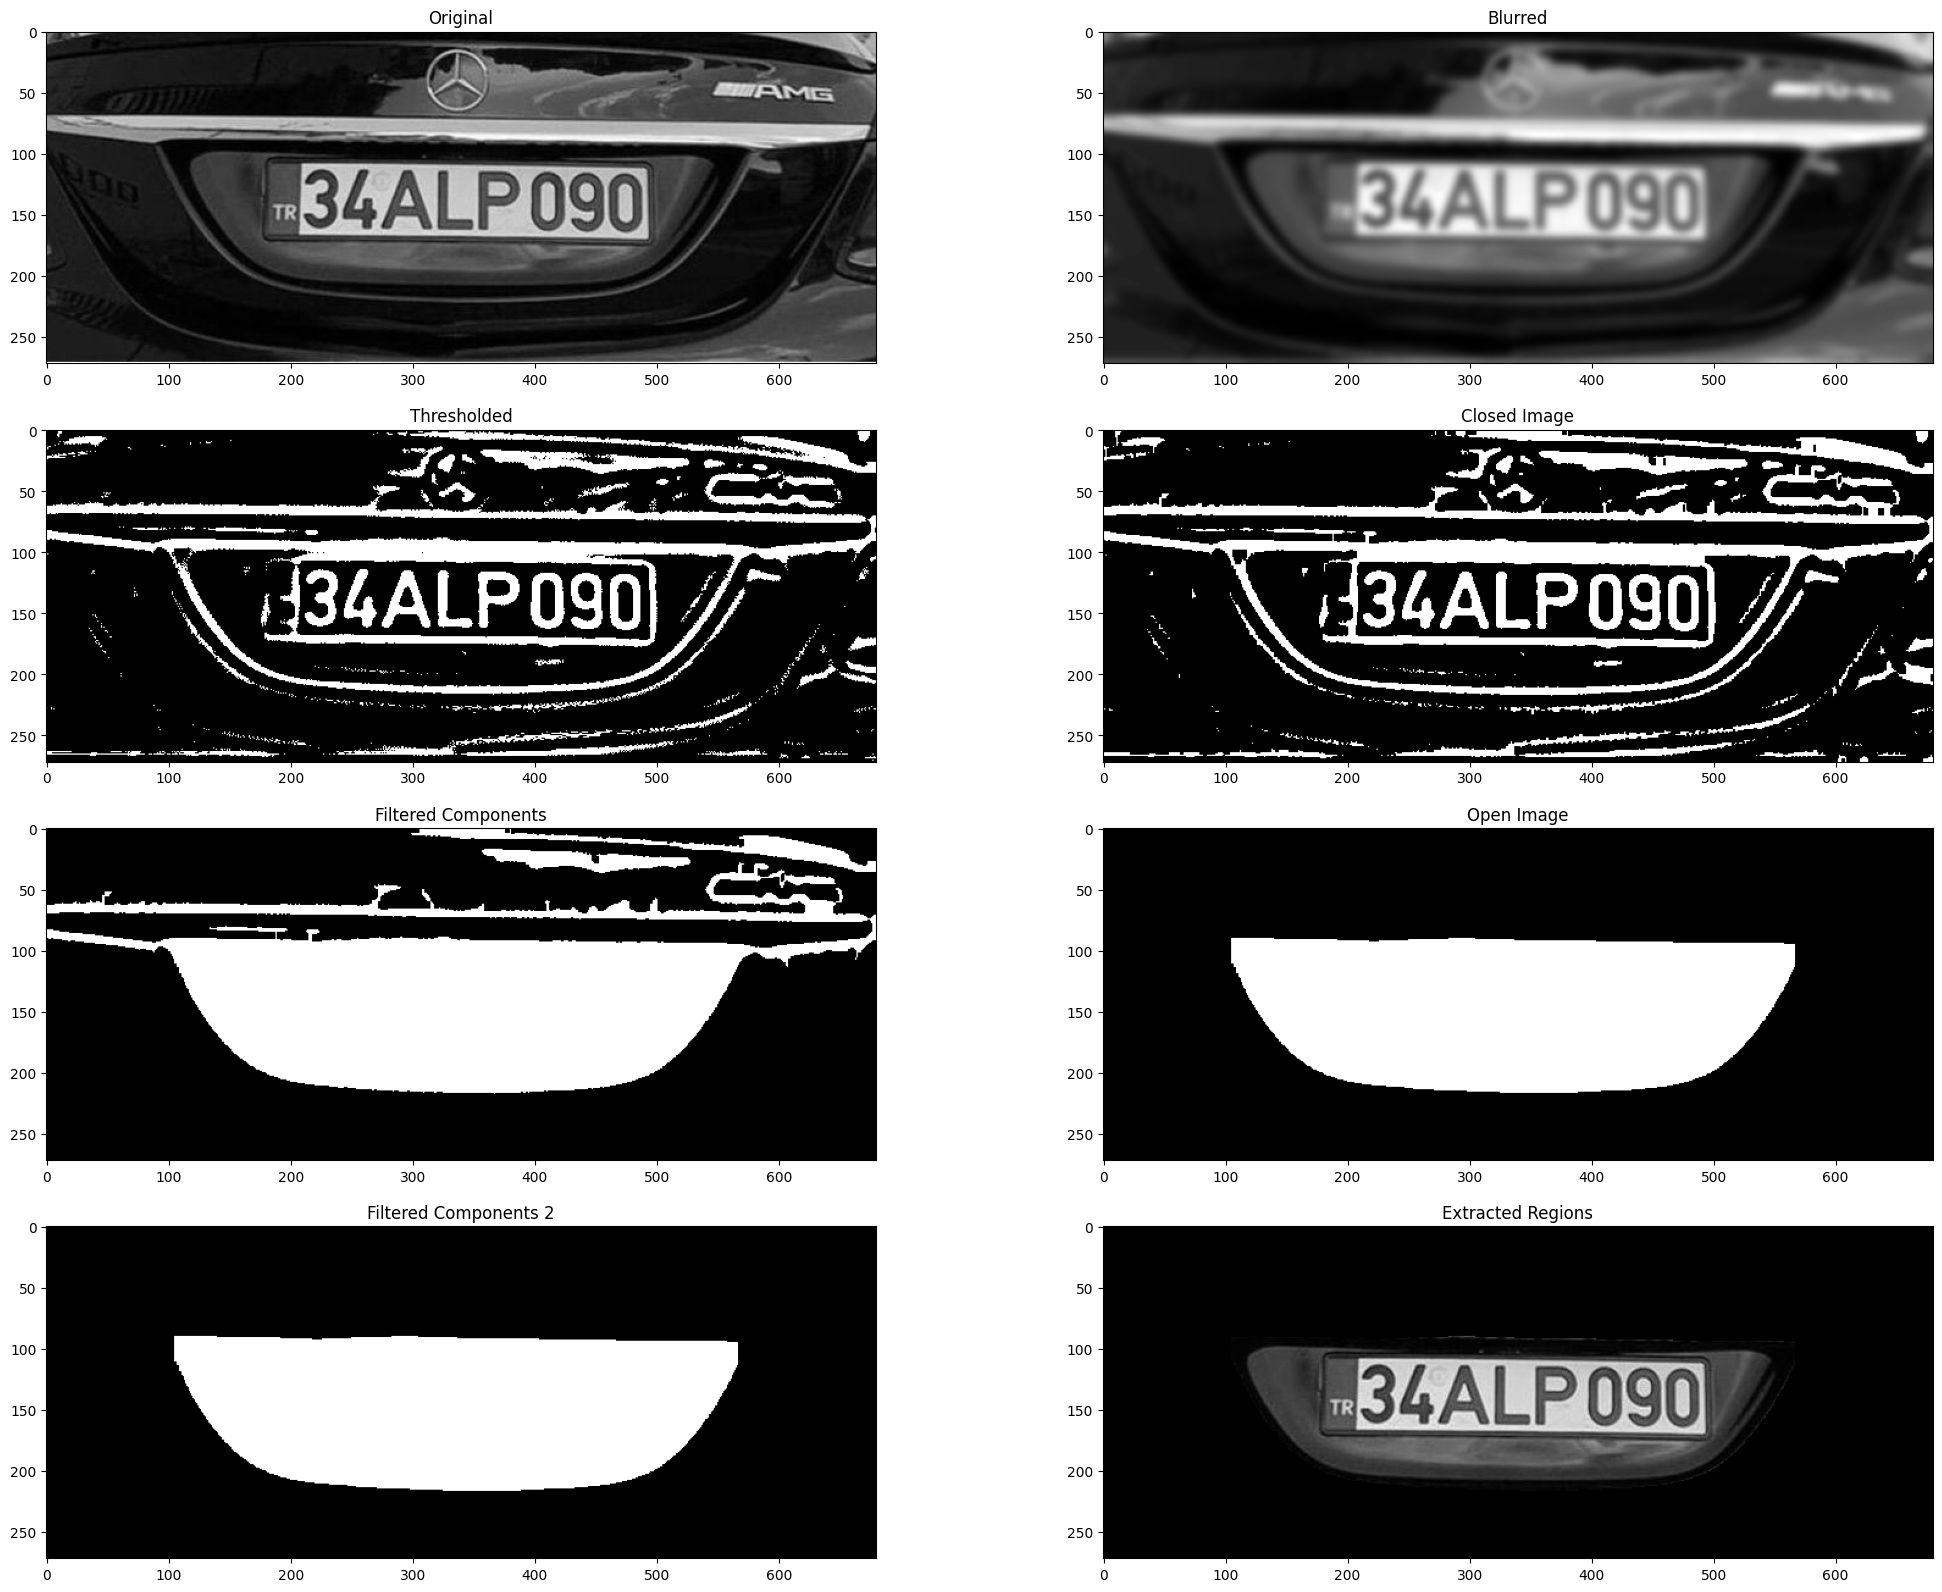

In [75]:
image_path = 'images_gray/train_images/train_easy2.jpg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(25, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()

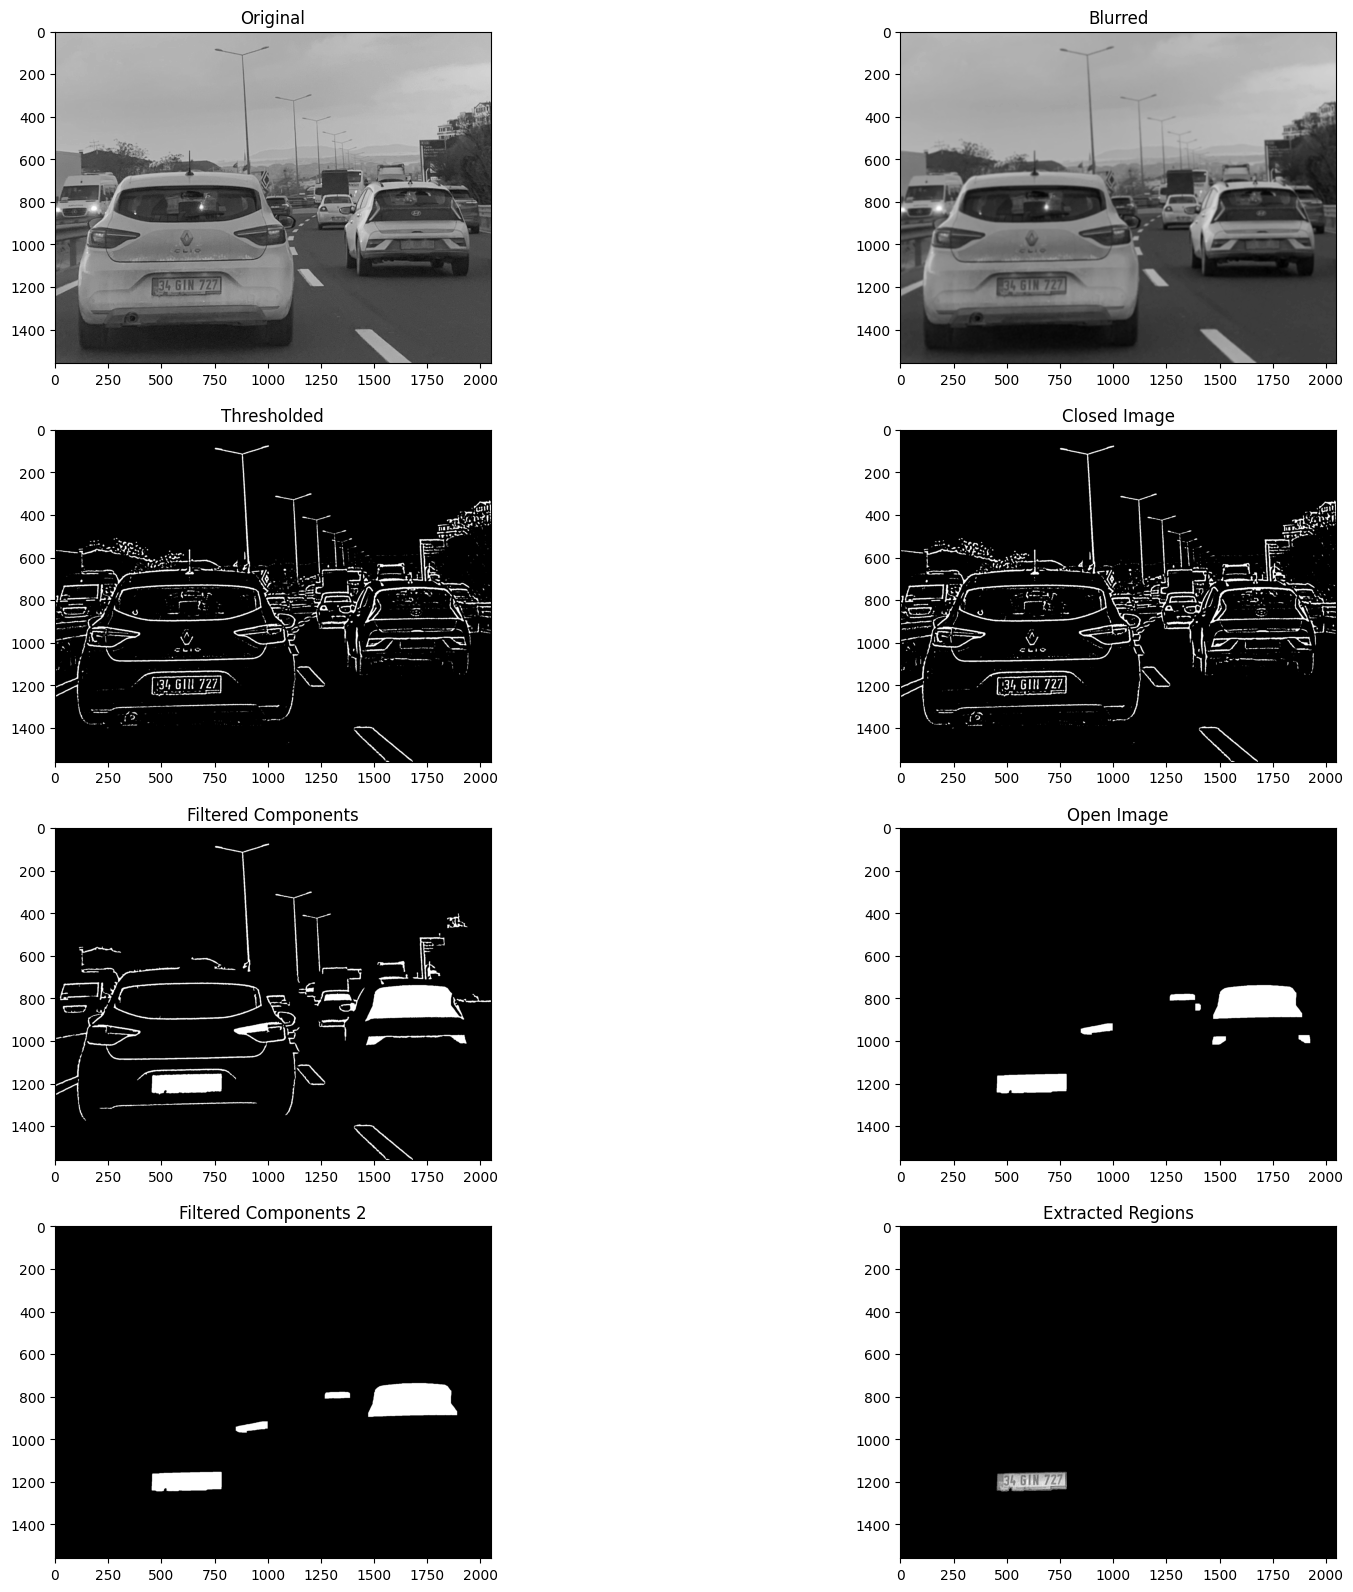

In [76]:
image_path = 'images_gray/train_images/train_hard1.jpeg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(20, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()

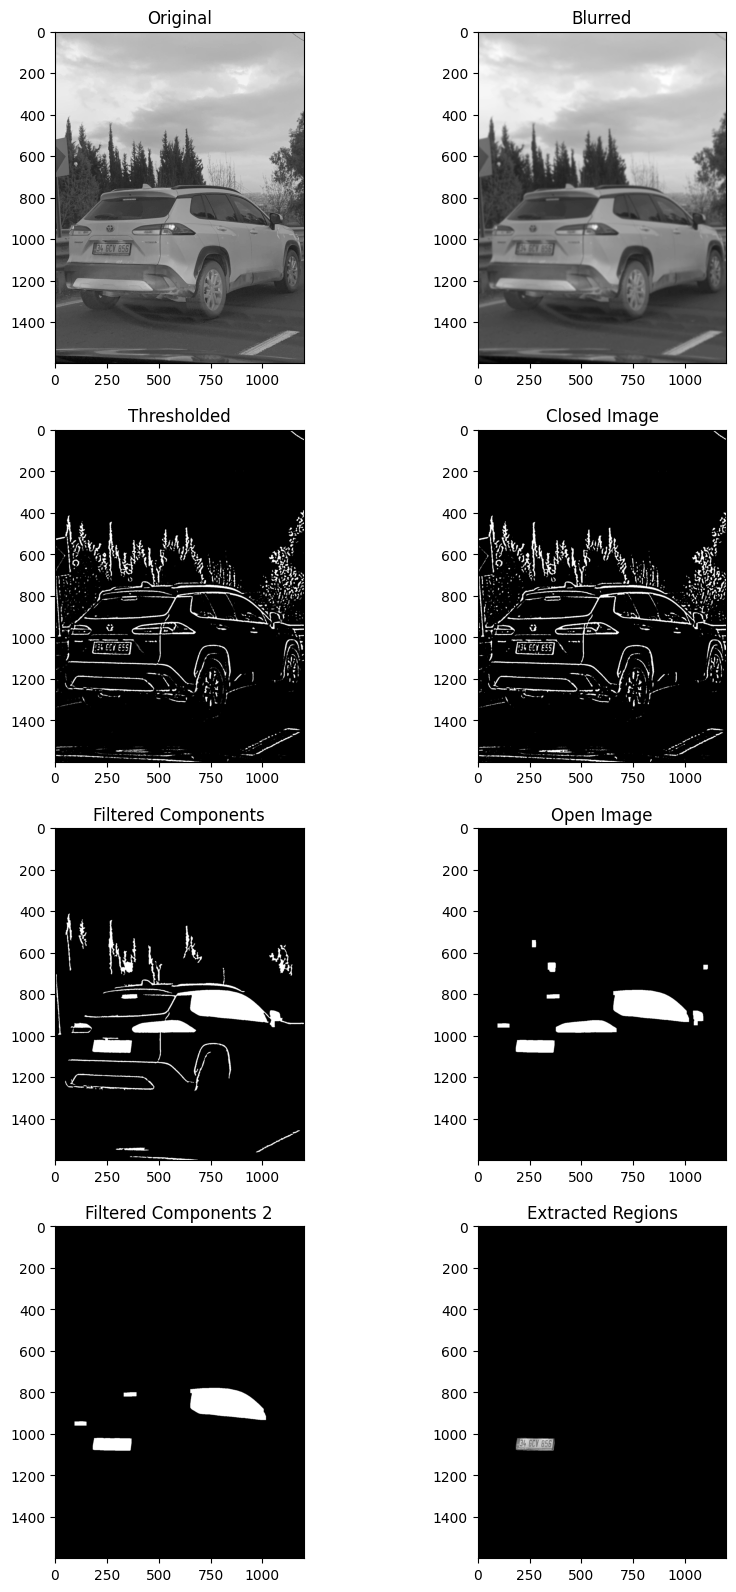

In [77]:
image_path = 'images_gray/train_images/train_medium1.jpg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(10, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()

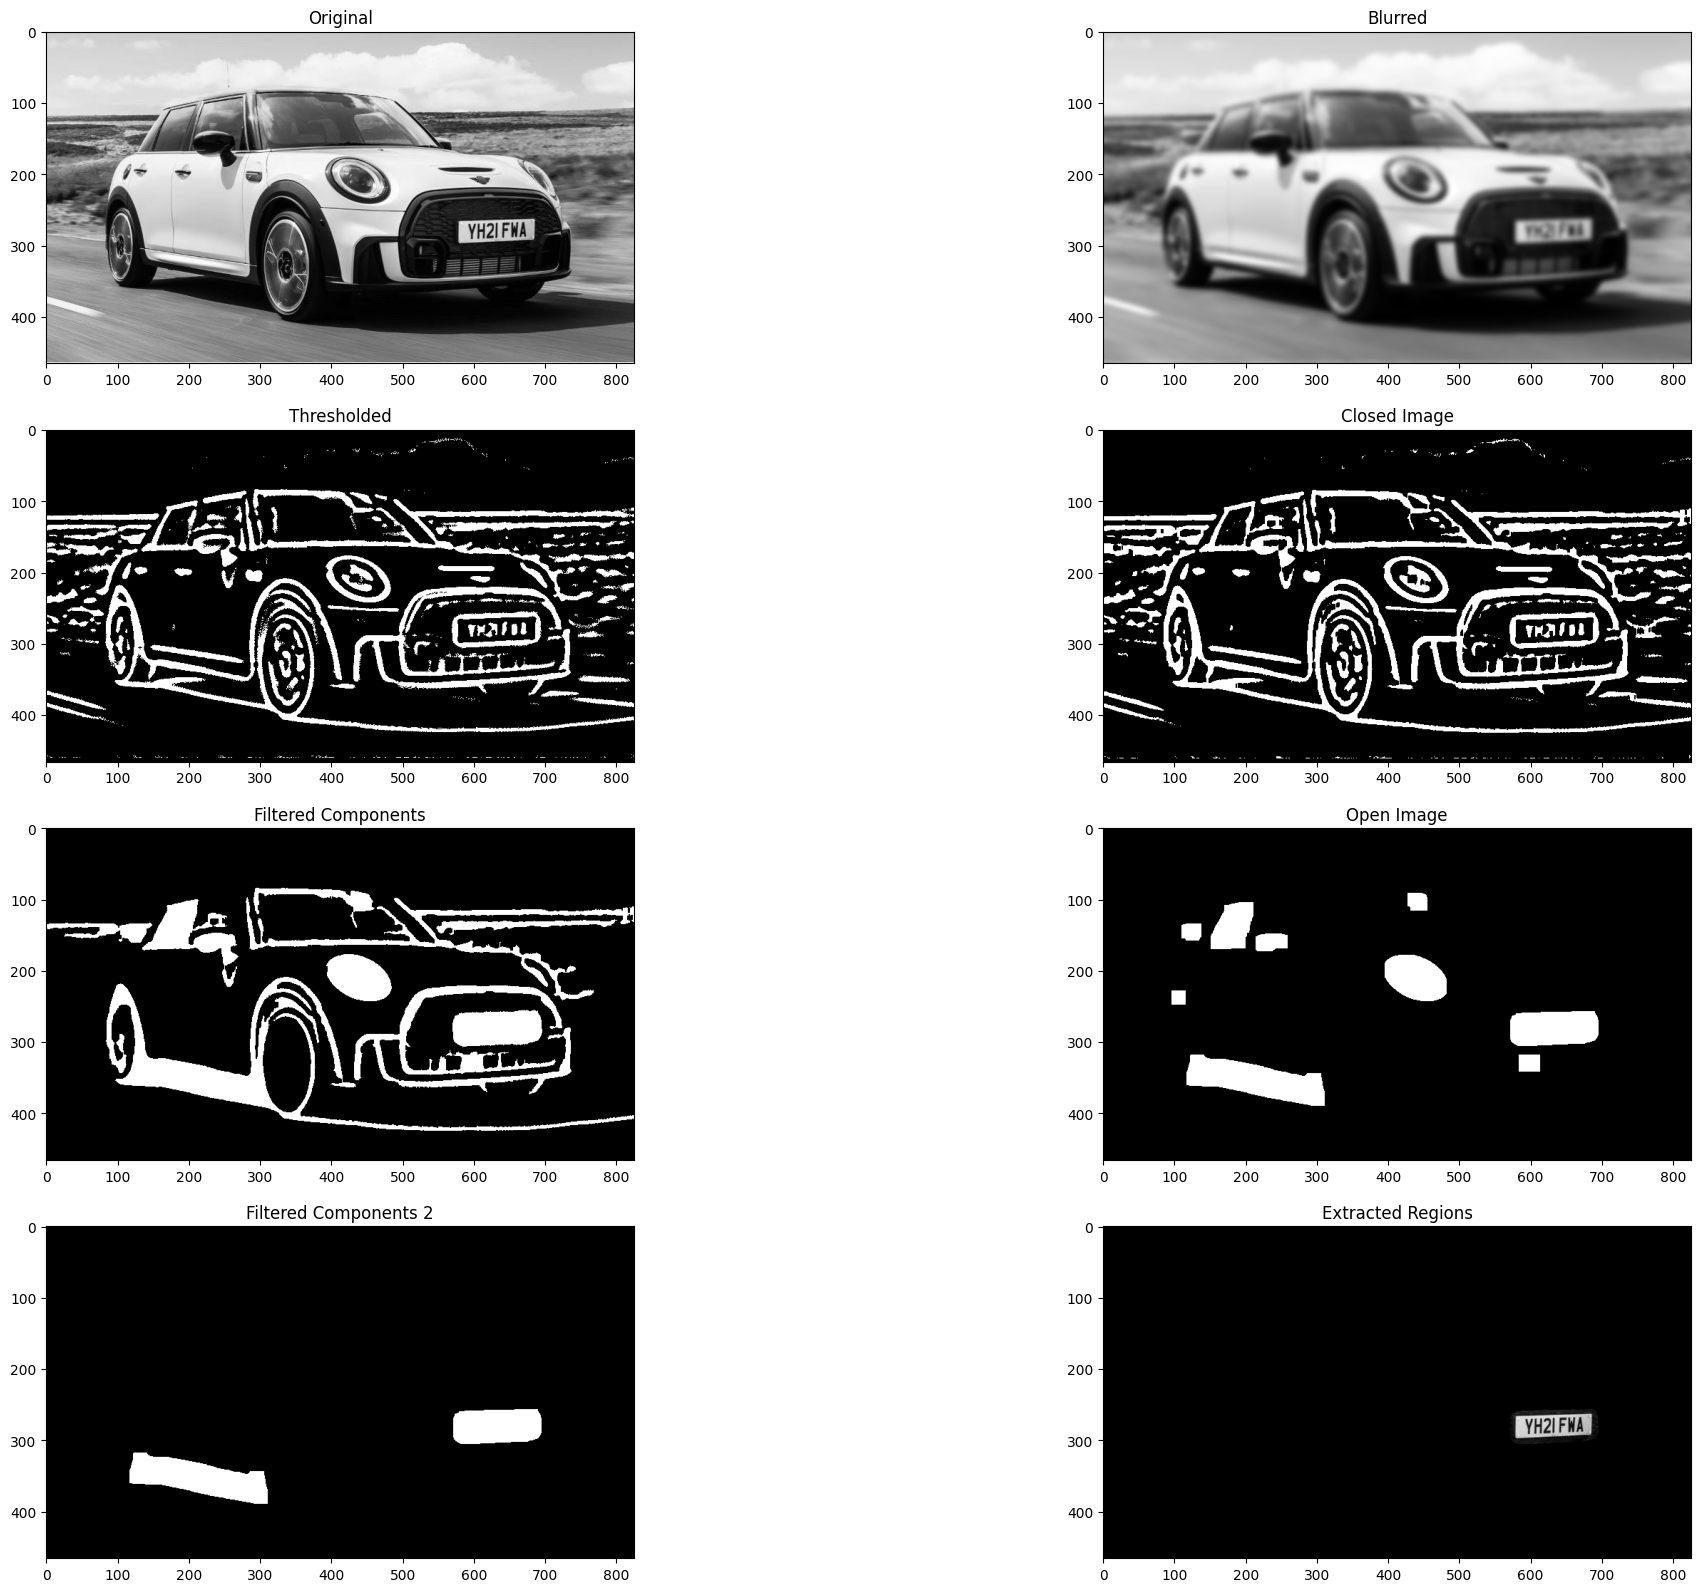

In [78]:
image_path = 'images_gray/test_images/test_medium1.jpg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(25, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()

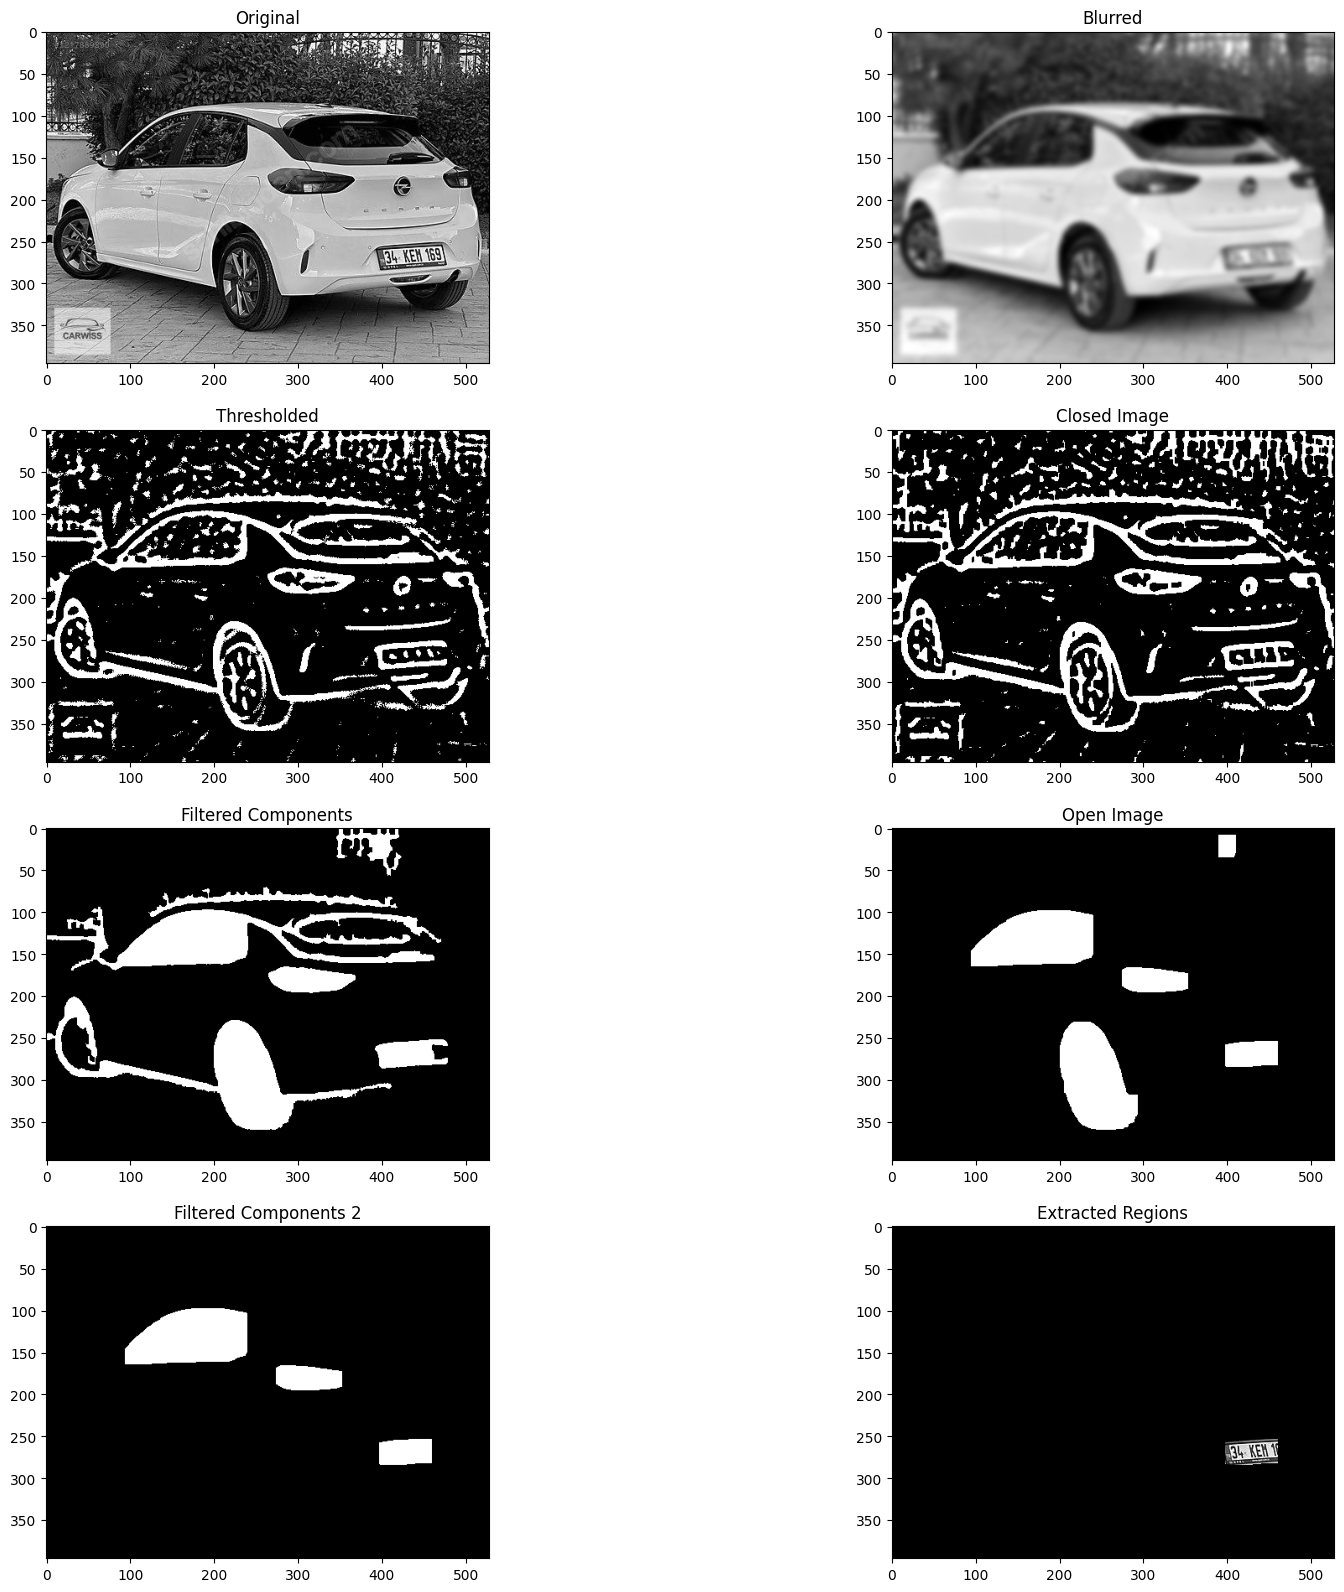

In [79]:
image_path = 'images_gray/test_images/test_medium2.jpg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(20, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


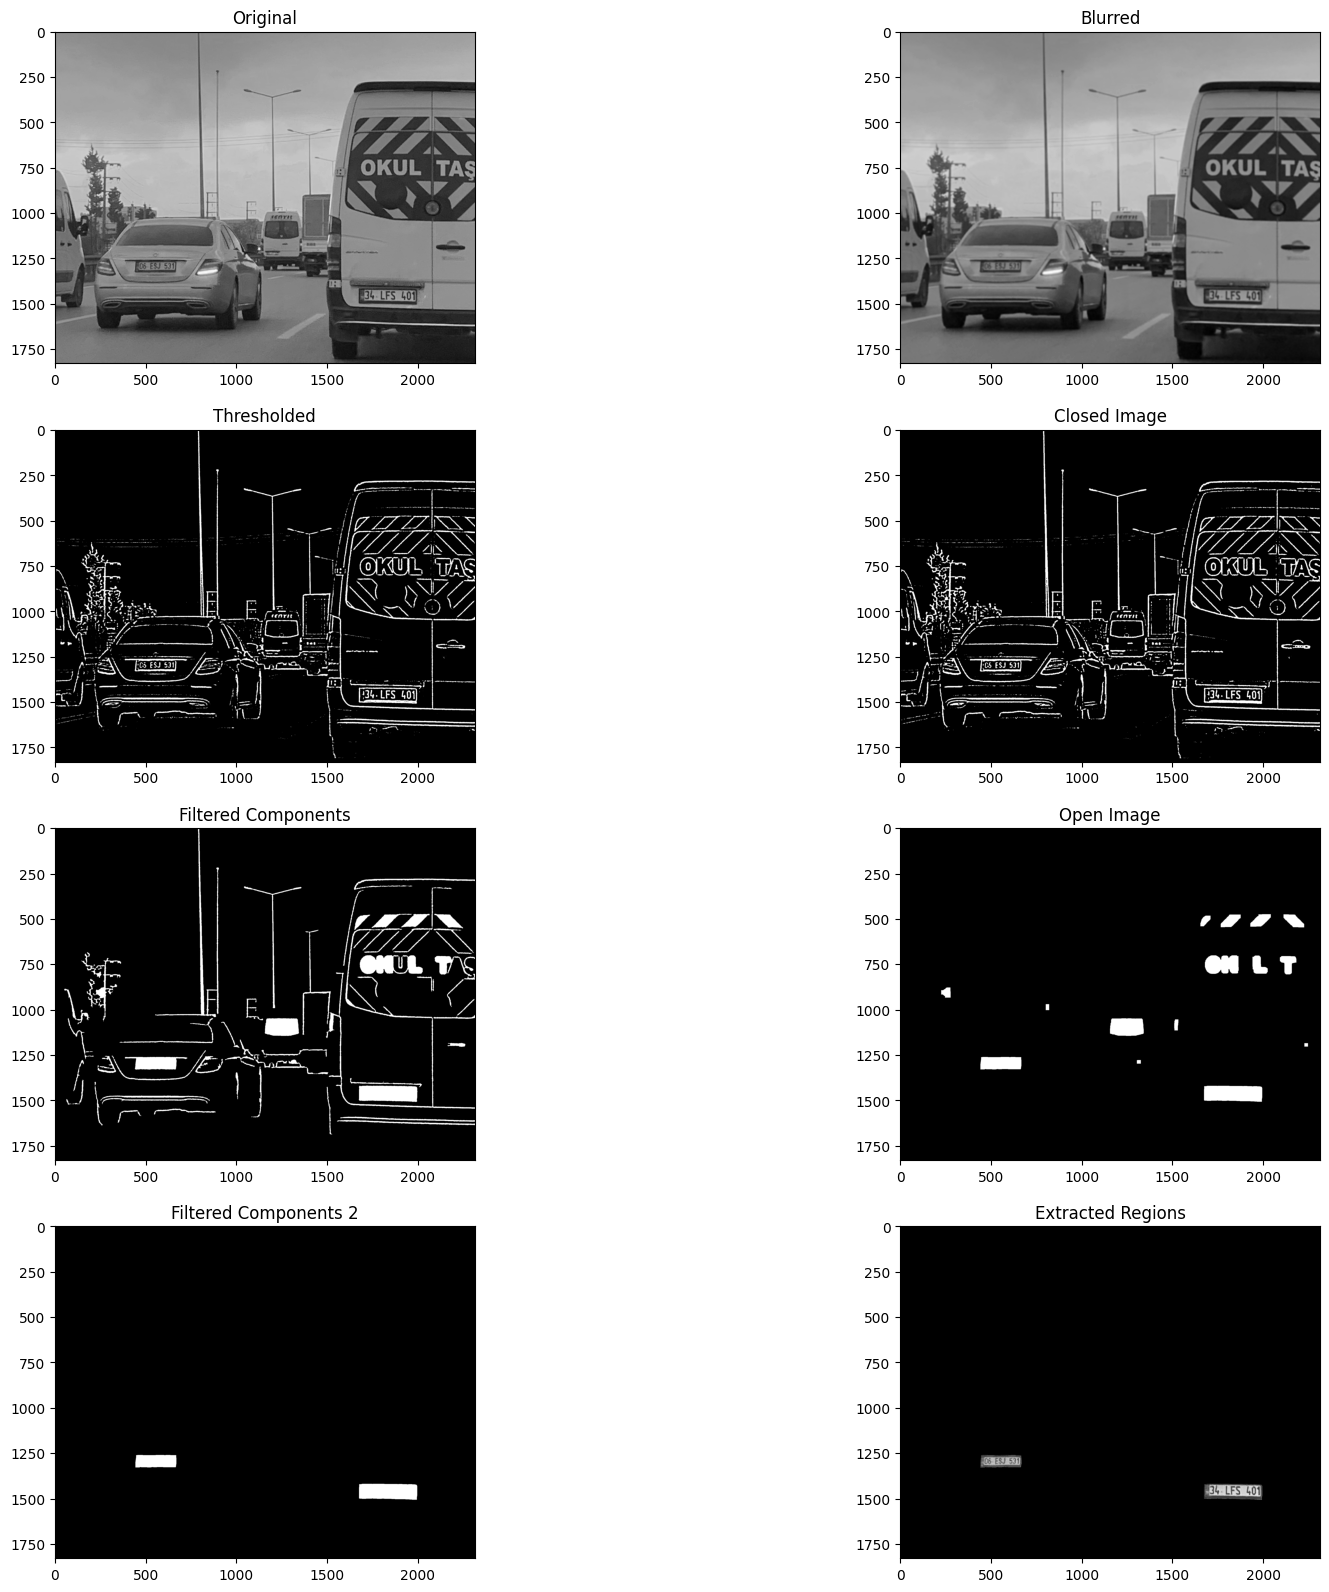

In [80]:
image_path = 'images_gray/test_images/test_hard1.png'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(20, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()

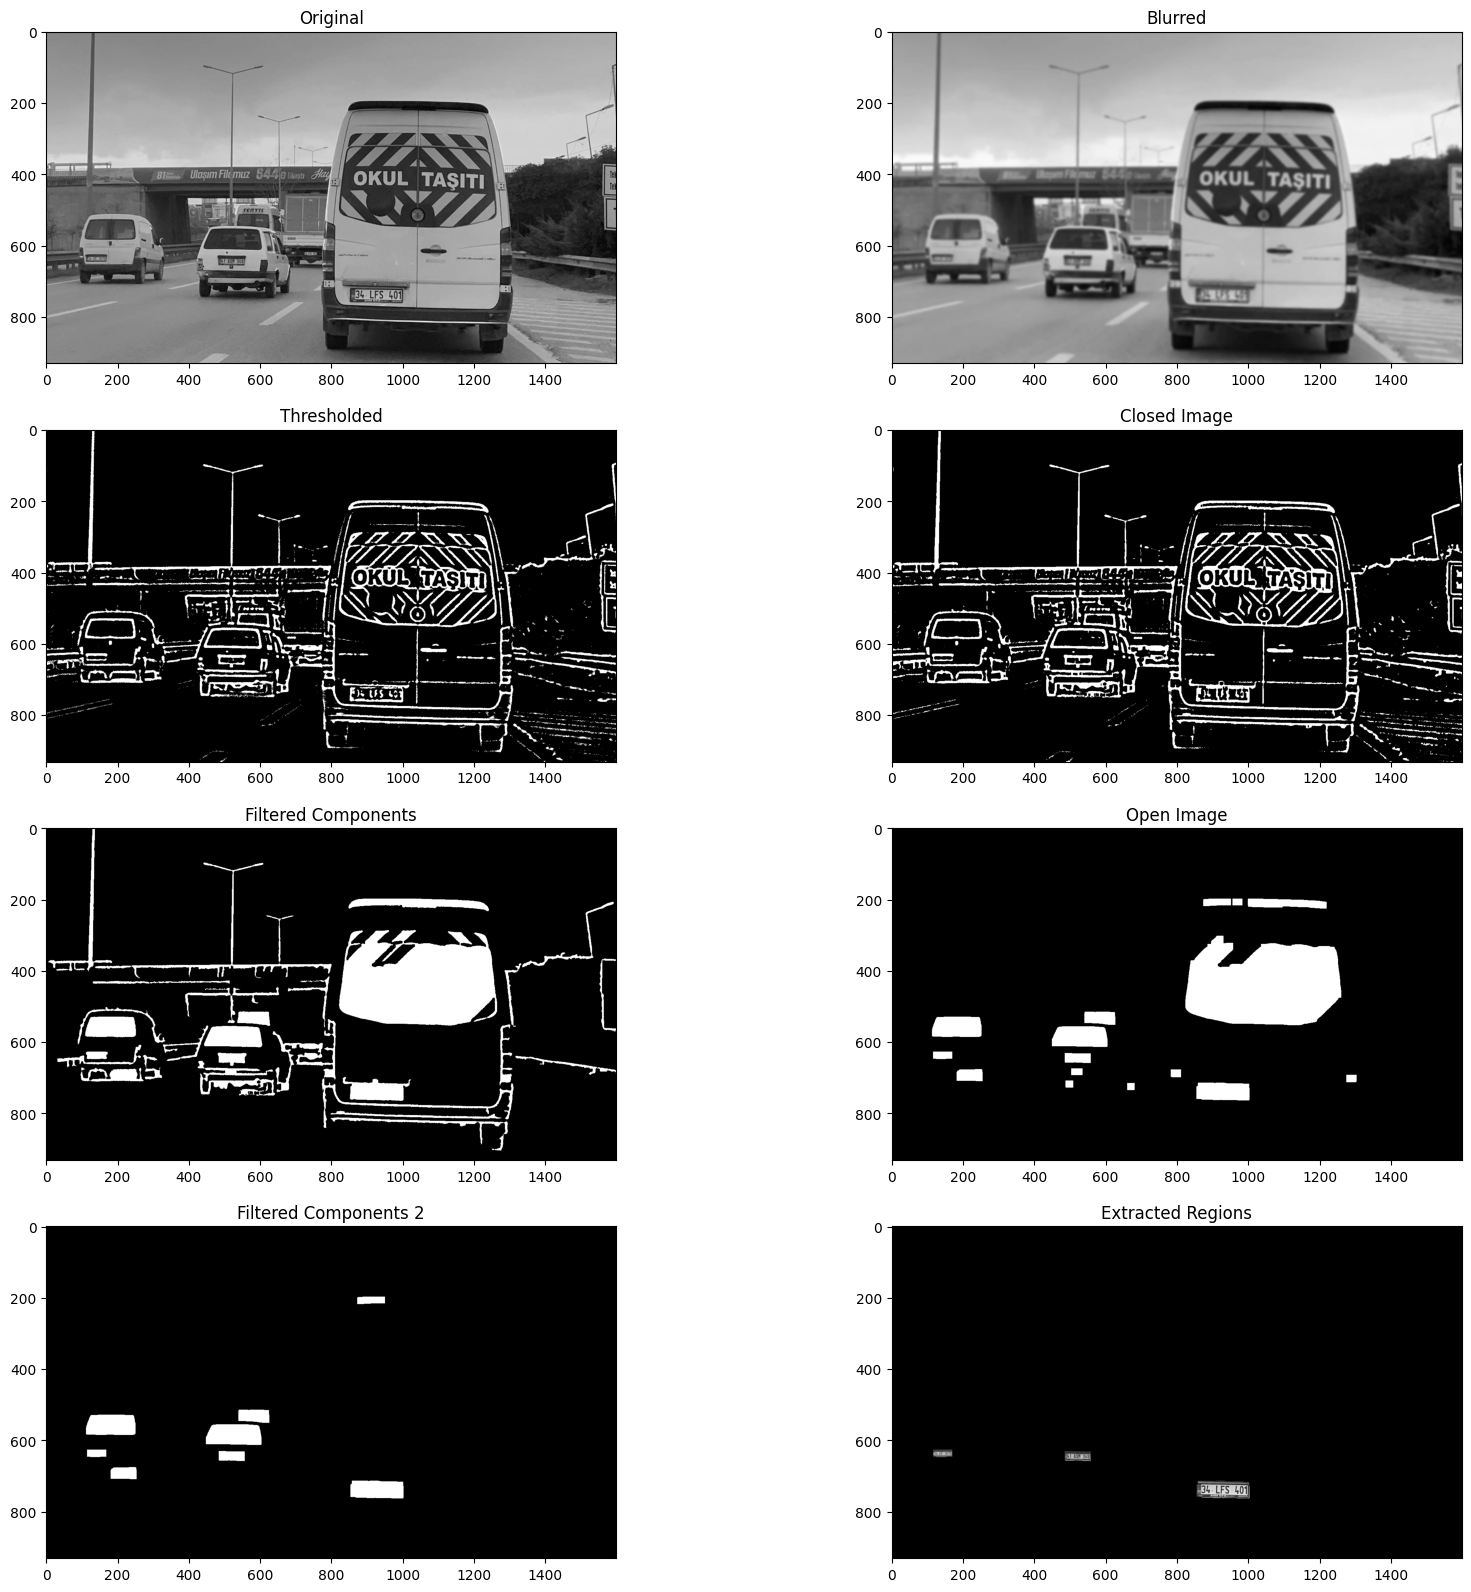

In [81]:
image_path = 'images_gray/test_images/test_hard2.jpeg'
gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components = process_image(image_path)

titles = ['Original', 'Blurred', 'Thresholded', 'Closed Image', 'Filtered Components', 'Open Image', 'Filtered Components 2', 'Extracted Regions']
images = [gray, blurred, thresh, closed_image, filtered_components, open_image, filtered_components_2, extracted_components]

plt.figure(figsize=(20, 25))

for i in range(len(images)):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.show()